In [ ]:
pip install vit-pytorch linformer

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [ ]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

In [28]:
import zipfile   

In [ ]:
from sklearn.model_selection import train_test_split  

In [ ]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7

In [33]:
pip install kaggle

In [34]:
! mkdir ~/.kaggle

In [35]:
cp kaggle.json ~/.kaggle/

In [36]:
! chmod 600 ~/.kaggle/kaggle.json

In [38]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 44.3MB/s]
 98% 535M/544M [00:03<00:00, 173MB/s]
100% 544M/544M [00:03<00:00, 146MB/s]
 97% 262M/271M [00:01<00:00, 172MB/s]
100% 271M/271M [00:02<00:00, 137MB/s]


In [ ]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

In [41]:
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

In [42]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [43]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [44]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

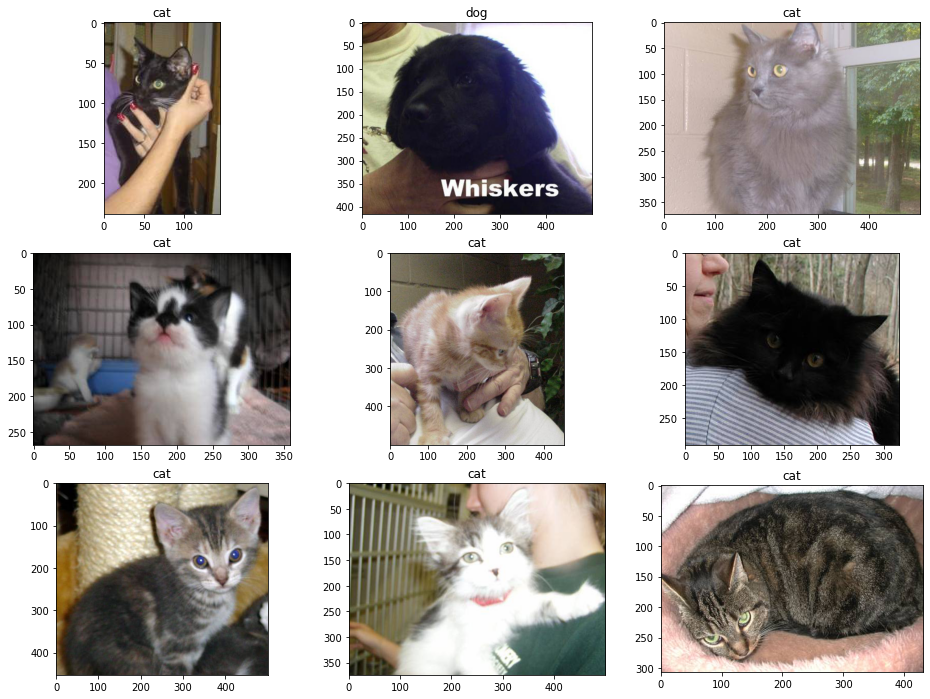

In [45]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


In [47]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=10)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [48]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [49]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [50]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [51]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [52]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [55]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [56]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [57]:
criterion = nn.CrossEntropyLoss()

In [58]:
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [60]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6713 - acc: 0.5798 - val_loss : 0.6722 - val_acc: 0.5831



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6600 - acc: 0.5926 - val_loss : 0.6506 - val_acc: 0.6119



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6502 - acc: 0.6085 - val_loss : 0.6517 - val_acc: 0.6019



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6463 - acc: 0.6115 - val_loss : 0.6438 - val_acc: 0.6185



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6420 - acc: 0.6218 - val_loss : 0.6396 - val_acc: 0.6268



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6339 - acc: 0.6305 - val_loss : 0.6262 - val_acc: 0.6383



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6272 - acc: 0.6406 - val_loss : 0.6266 - val_acc: 0.6331



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6231 - acc: 0.6429 - val_loss : 0.6145 - val_acc: 0.6472



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6190 - acc: 0.6461 - val_loss : 0.6371 - val_acc: 0.6145



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6104 - acc: 0.6553 - val_loss : 0.6145 - val_acc: 0.6570



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6071 - acc: 0.6608 - val_loss : 0.6120 - val_acc: 0.6564



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6021 - acc: 0.6663 - val_loss : 0.6007 - val_acc: 0.6744



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5974 - acc: 0.6702 - val_loss : 0.6110 - val_acc: 0.6616



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5966 - acc: 0.6740 - val_loss : 0.5943 - val_acc: 0.6703



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5945 - acc: 0.6769 - val_loss : 0.5906 - val_acc: 0.6770



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5883 - acc: 0.6810 - val_loss : 0.5979 - val_acc: 0.6764



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5870 - acc: 0.6848 - val_loss : 0.5883 - val_acc: 0.6816



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5837 - acc: 0.6816 - val_loss : 0.5862 - val_acc: 0.6839



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5803 - acc: 0.6893 - val_loss : 0.5917 - val_acc: 0.6828



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5828 - acc: 0.6842 - val_loss : 0.5867 - val_acc: 0.6784

